In [1]:
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from operator import itemgetter
from itertools import groupby
import seaborn as sns
from sklearn.model_selection import cross_val_score


In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
# Read the data in pandas
data = pd.read_csv("data_for_student_case.csv")
data['bookingdate'] =  pd.to_datetime(data['bookingdate'])
data['creationdate'] =  pd.to_datetime(data['creationdate'])

In [4]:
# Show the first entries
data.head()
# data['simple_journal'].unique()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [5]:
# Delete the refused transactions (but keep them for later use maybe)

refused_data = data.loc[data['simple_journal'] == "Refused", :]
dataset = data.loc[data['simple_journal'] != "Refused", :]
dataset['bool_fraud'] = (dataset['simple_journal'] == "Chargeback").copy().astype(int)
dataset['bool_valid'] = (dataset['simple_journal'] == "Settled").copy().astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# Do some preprocessing for the ML algorithms
finalset = dataset.copy()
finalset['mail_id'] = finalset['mail_id'].str.replace('email','')
finalset['ip_id'] = finalset['ip_id'].str.replace('ip','')
finalset['card_id'] = finalset['card_id'].str.replace('card','')


In [7]:
# Group on dates
creation_dailygroup_mean = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).mean()
creation_monthlygroup_mean = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).mean()
booking_dailygroup_mean = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).mean()
booking_monthlygroup_mean = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).mean()

creation_dailygroup_sum = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).sum()
creation_monthlygroup_sum = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).sum()
booking_dailygroup_sum = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).sum()
booking_monthlygroup_sum = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).sum()

creation_dailygroup_count = finalset.groupby(pd.Grouper(key='creationdate',freq='D')).count()
creation_monthlygroup_count = finalset.groupby(pd.Grouper(key='creationdate',freq='M')).count()
booking_dailygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='D')).count()
booking_monthlygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).count()

# Group on simple_journal
booking_monthlygroup_count = finalset.groupby(pd.Grouper(key='bookingdate',freq='M')).count()

# Group on card id
card_id_sum = finalset.groupby('card_id').sum()
ip_id_sum = finalset.groupby('ip_id').sum()
mail_id_sum = finalset.groupby('mail_id').sum()

accountcode_sum = finalset.groupby('accountcode').sum()


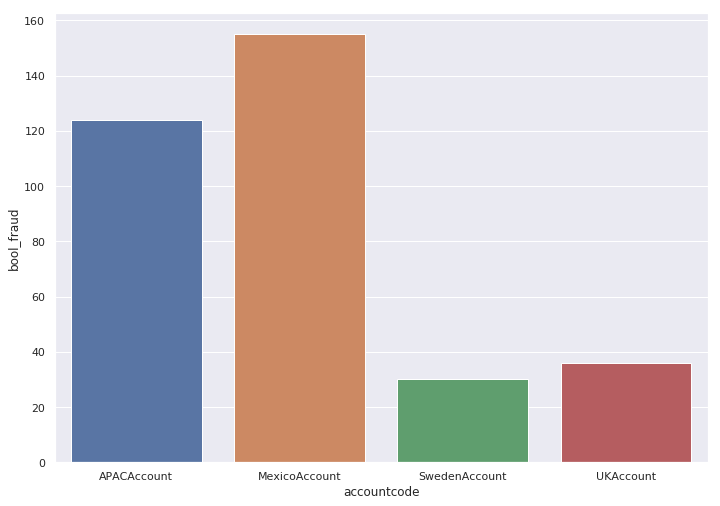

In [8]:
sns.barplot(x=accountcode_sum.index, y="bool_fraud",data=accountcode_sum)

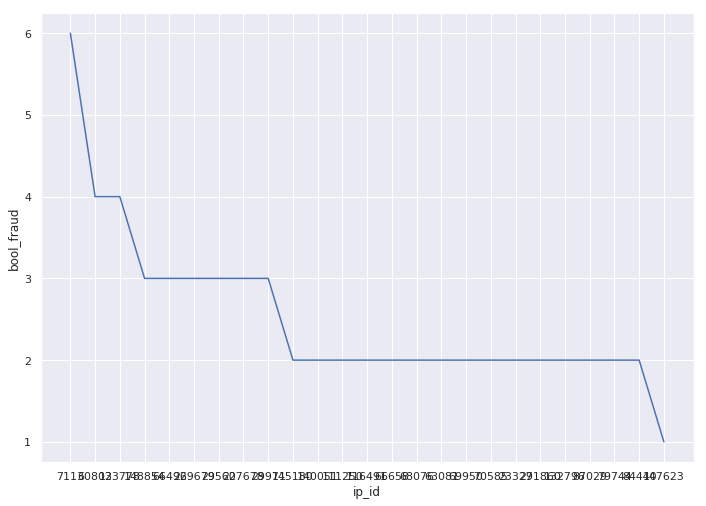

In [9]:
sorted_ips = ip_id_sum.sort_values("bool_fraud",ascending=False).head(25)
sns.lineplot(data=sorted_ips, x=sorted_ips.index, sort=False, y="bool_fraud")


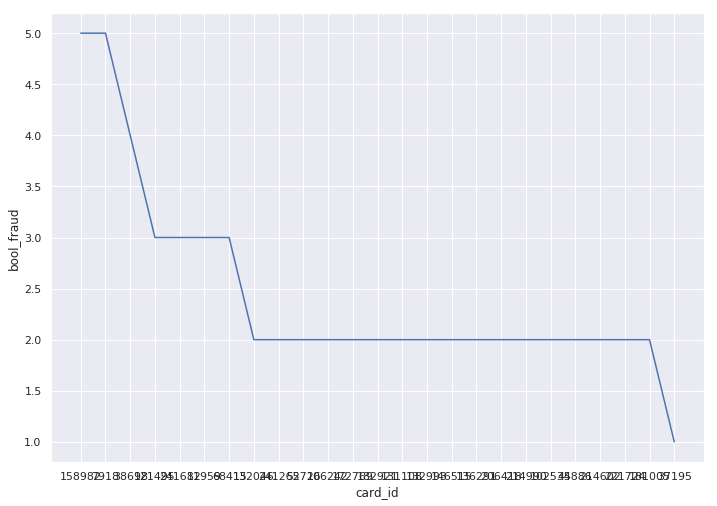

In [10]:
sorted_cards = card_id_sum.sort_values("bool_fraud",ascending=False).head(25)
sns.lineplot(data=sorted_cards, x=sorted_cards.index, sort=False, y="bool_fraud")

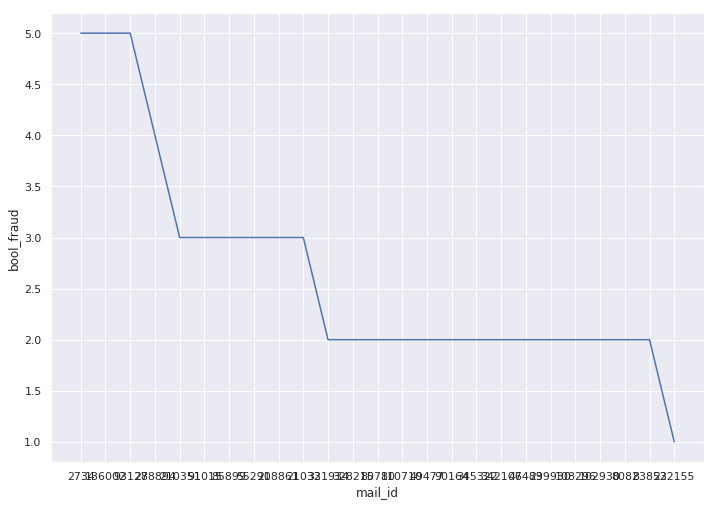

In [11]:

sorted_cards = mail_id_sum.sort_values("bool_fraud",ascending=False).head(25)
sns.lineplot(data=sorted_cards, x=sorted_cards.index, sort=False, y="bool_fraud")

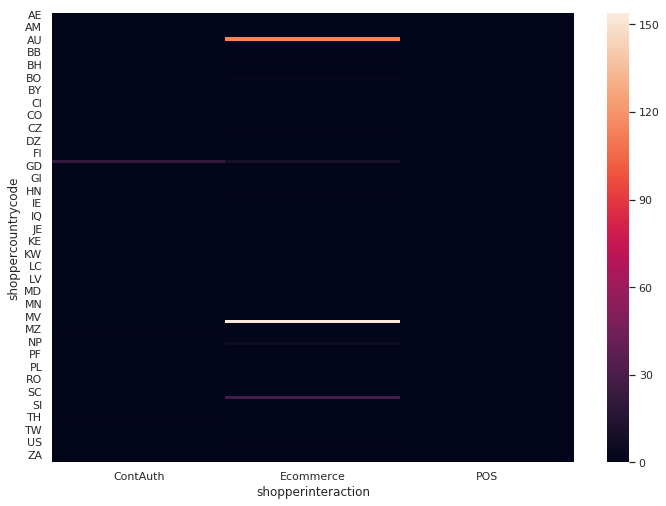

In [12]:
# Heatmap stuff
heatmap_data = pd.pivot_table(finalset, "simple_journal", "shoppercountrycode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data.fillna(0))



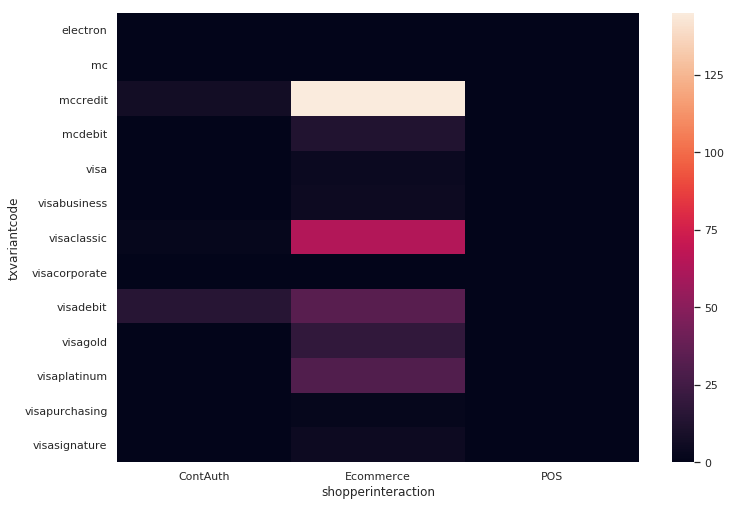

In [13]:
# Heatmap stuff
heatmap_data = pd.pivot_table(finalset, "simple_journal", "txvariantcode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data.fillna(0))

In [14]:
finalset.columns

Index(['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id',
       'bool_fraud', 'bool_valid'],
      dtype='object')

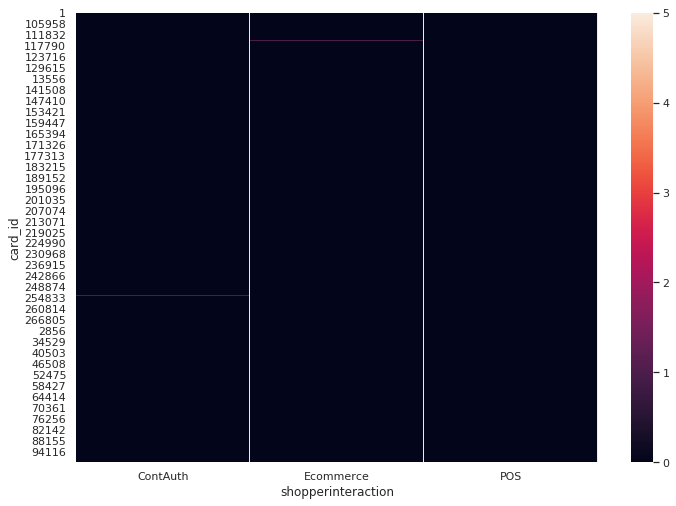

In [15]:
# Heatmap stuff
heatmap_data = pd.pivot_table(finalset, "simple_journal", "card_id","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
ax = sns.heatmap(heatmap_data.fillna(0))

In [16]:
# # Heatmap stuff
# heatmap_data = pd.pivot_table(finalset, "simple_journal", "ip_id","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
# ax = sns.heatmap(heatmap_data)

In [17]:
# # Heatmap stuff
# heatmap_data = pd.pivot_table(finalset, "simple_journal", "accountcode","shopperinteraction", aggfunc=lambda x: sum(x == "Chargeback"))
# ax = sns.heatmap(heatmap_data)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[Text(0, 0, '2015-07-01'),
 Text(0, 0, '2015-07-02'),
 Text(0, 0, '2015-07-03'),
 Text(0, 0, '2015-07-04'),
 Text(0, 0, '2015-07-05'),
 Text(0, 0, '2015-07-06'),
 Text(0, 0, '2015-07-07'),
 Text(0, 0, '2015-07-08'),
 Text(0, 0, '2015-07-09'),
 Text(0, 0, '2015-07-10'),
 Text(0, 0, '2015-07-11'),
 Text(0, 0, '2015-07-12'),
 Text(0, 0, '2015-07-13'),
 Text(0, 0, '2015-07-14')]

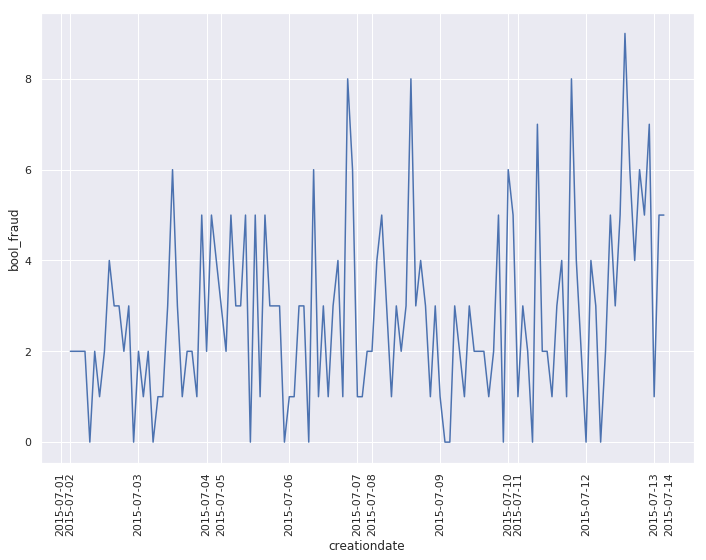

In [18]:
# multiple line plot
ax = sns.lineplot(x=creation_dailygroup_sum.index, y="bool_fraud", data=creation_dailygroup_sum)
ax.set_xticklabels(labels = [d.date() for d in creation_dailygroup_sum.index], rotation=90)

In [1]:
# multiple line plot
ax = sns.barplot(x=creation_monthlygroup_sum.index, y="bool_fraud", data=creation_monthlygroup_sum)
ax.set_xticklabels(labels = [d.date() for d in creation_monthlygroup_sum.index], rotation=90)

NameError: name 'sns' is not defined

In [20]:
creation_monthlygroup_sum.index

DatetimeIndex(['2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31'], dtype='datetime64[ns]', name='creationdate', freq='M')

In [21]:
# issuercountry
# txvariantcode
# currencycode
# shoppercountry
# interaction
# verification
# accountcode



In [13]:
finalset.columns

Index(['txid', 'bookingdate', 'issuercountrycode', 'txvariantcode', 'bin',
       'amount', 'currencycode', 'shoppercountrycode', 'shopperinteraction',
       'simple_journal', 'cardverificationcodesupplied', 'cvcresponsecode',
       'creationdate', 'accountcode', 'mail_id', 'ip_id', 'card_id',
       'bool_fraud', 'bool_valid'],
      dtype='object')

In [14]:
targets_for_onehot = ['issuercountrycode', 'txvariantcode','currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'cvcresponsecode']

new_df = pd.DataFrame([])

for target in targets_for_onehot:
    temp = pd.get_dummies(finalset[target])
    new_df = pd.concat([new_df, temp],axis=1)
    
new_df = pd.concat([new_df, finalset[['mail_id','ip_id','card_id','bin','amount']]], axis=1)
new_df = new_df.fillna(0)

In [15]:
def print_scores(y_predict, y_true):
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(len(y_predict)):
        if y_true[i]==1 and y_predict[i]==1:
            TP += 1
        if y_true[i]==0 and y_predict[i]==1:
            FP += 1
        if y_true[i]==1 and y_predict[i]==0:
            FN += 1
        if y_true[i]==0 and y_predict[i]==0:
            TN += 1
    print('TP: '+ str(TP))
    print('FP: '+ str(FP))
    print('FN: '+ str(FN))
    print('TN: '+ str(TN))


In [16]:

x = new_df.values
x[x=="NA"] = 0
y = finalset['bool_fraud'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)#test_size: proportion of train/test data
clf = neighbors.KNeighborsClassifier(algorithm = 'auto')
clf.fit(x_train, y_train)
y_predict = clf.predict(x_test)

print_scores(y_predict, y_test)

#print confusion_matrix(y_test, answear) watch out the element in confusion matrix
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)
predict_proba = clf.predict_proba(x_test)#the probability of each smple labelled to positive or negative

TP: 0
FP: 1
FN: 32
TN: 23671


In [ ]:
from sklearn import svm
from imblearn.under_sampling import RandomUnderSampler
## Run the svm - too slow


clf = svm.LinearSVC(C=1, class_weight={0:1, 1:100},max_iter=10000).fit(x_train, y_train)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC

n_estimators = 50
start = time.time()
clf = BaggingClassifier(SVC(kernel='linear', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators, n_jobs=-1)
clf.fit(x_train, y_train)
end = time.time()
print("Bagging SVC" + str(end - start))
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)


start = time.time()
clf = RandomForestClassifier(min_samples_leaf=20, n_jobs=-1)
clf.fit(x_train, y_train)
end = time.time()
print("Random Forest" + str(end - start))
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

In [13]:
from sklearn import tree

## Run the decision tree
clf = tree.DecisionTreeClassifier(class_weight={0:1, 1:1000}).fit(x_train, y_train)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

TP: 8
FP: 16
FN: 31
TN: 23649


In [29]:
from sklearn.ensemble import AdaBoostClassifier

## Run the AdaBoost class
clf = AdaBoostClassifier(n_estimators=50, base_estimator=tree.DecisionTreeClassifier(class_weight={0:1, 1:20}, max_depth=1)).fit(x_train, y_train)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

TP: 5
FP: 140
FN: 34
TN: 23525


In [30]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Run the bagging
clf = BaggingClassifier(tree.DecisionTreeClassifier(class_weight={0:1, 1:50}),max_samples=0.5, max_features=0.5).fit(x_train, y_train)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

TP: 4
FP: 0
FN: 35
TN: 23665


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Run the Forsest
clf = RandomForestClassifier(n_estimators=20,class_weight={0:1, 1:50}).fit(x_train, y_train)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

In [23]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import cross_validate

In [1]:
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),
           'fp': make_scorer(fp), 'fn': make_scorer(fn)}

untrained_clf = AdaBoostClassifier(n_estimators=50, base_estimator=tree.DecisionTreeClassifier(class_weight={0:1, 1:10}, max_depth=1))
cv_results = cross_validate(untrained_clf.fit(x, y), x, y, scoring=scoring, cv=10)

NameError: name 'make_scorer' is not defined

In [ ]:
cv_results

In [32]:
!pip3 install imblearn

    100% |████████████████████████████████| 174kB 1.1MB/s ta 0:00:01


In [51]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE()
x_train_smoted, y_train_smoted = sm.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_smoted))


Original dataset shape Counter({0: 213015, 1: 317})
Resampled dataset shape Counter({0: 213015, 1: 213015})


In [52]:
## Smoted

clf = tree.DecisionTreeClassifier(class_weight={0:1, 1:1000}).fit(x_train_smoted, y_train_smoted)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

## Normal
clf = tree.DecisionTreeClassifier(class_weight={0:1, 1:1000}).fit(x_train, y_train)
y_predict = clf.predict(x_test) 
print_scores(y_predict, y_test)

TP: 5
FP: 66
FN: 23
TN: 23610
TP: 3
FP: 27
FN: 25
TN: 23649
